In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-life-violence-and-nonviolence-data/violence_dataset/non_violence/NV_659.mp4_frame3.jpg
/kaggle/input/real-life-violence-and-nonviolence-data/violence_dataset/violence/V_841.mp4_frame4.jpg
/kaggle/input/adult-content-img/nsfw_dataset_v1/porn/249f3297db287314cc04c8da6e527c5b8d22af62db682c4287ca36f27bcf1e54.jpg
/kaggle/input/adult-content-img/nsfw_dataset_v1/hentai/2729135.jpg
/kaggle/input/adult-content-img/nsfw_dataset_v1/sexy/3888eac404a57f595ee00fc3bdd01ba1e64d2fbff130f585bb0265003740ebc1.jpg


In [2]:
!pip install keras==2.15.0

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tf_keras, witwidget


In [4]:
!pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: keras-tuner, tensorflow


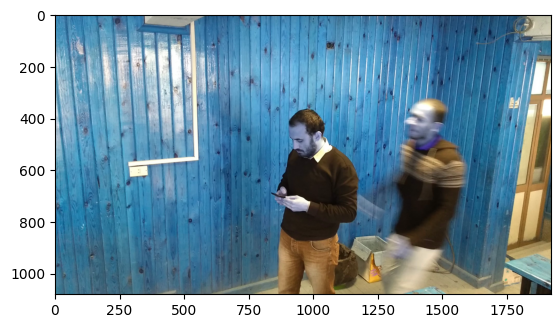

In [5]:
import matplotlib.pyplot as plt
import cv2

img=cv2.imread('/kaggle/input/real-life-violence-and-nonviolence-data/violence_dataset/violence/V_1.mp4_frame0.jpg')
plt.imshow(img)

In [6]:
violent_data_dir=[]
adult_data_dir=[]

for dirname, _, filenames in os.walk('/kaggle/input'):
    i=0
    for filename in filenames:
        path=os.path.join(dirname, filename)
        if(dirname=='/kaggle/input/real-life-violence-and-nonviolence-data/violence_dataset/violence'):
            violent_data_dir.append(path)
        elif(dirname!='/kaggle/input/real-life-violence-and-nonviolence-data/violence_dataset/non_violence'):
            i=i+1
            if(i>1167):
                break
            adult_data_dir.append(path)
            

In [7]:
len(violent_data_dir)
violent_data_dir=violent_data_dir[:3500]

In [8]:
len(adult_data_dir)
adult_data_dir=adult_data_dir[:3500]

In [9]:
adult_data_dir[0]

'/kaggle/input/adult-content-img/nsfw_dataset_v1/porn/249f3297db287314cc04c8da6e527c5b8d22af62db682c4287ca36f27bcf1e54.jpg'

In [10]:
images_dict = {
    'violent' : violent_data_dir,
    'adult' : adult_data_dir,
}

In [11]:
label_dict = {
    'violent' : 0,
    'adult' : 1,
}

In [12]:
X=[]
y=[]

for cat,images in images_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        resized_img=cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(label_dict[cat])

In [13]:
X = np.array(X)
X=X/255
y = np.array(y)                                                                        

In [14]:
X.shape

(7000, 224, 224, 3)

In [15]:
y.shape

(7000,)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1 , shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle=True) #.25 x 0.8 = 0.2

In [17]:
X_train.shape

(4200, 224, 224, 3)

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50


resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

2024-06-11 21:33:27.565932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 21:33:27.566034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 21:33:27.692467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

In [20]:
my_model = Sequential([
  resnet_50,
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

In [21]:
my_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [22]:
my_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10,batch_size=64)  

Epoch 1/10


I0000 00:00:1718141636.037818    2281 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 [==============================] - 42s 436ms/step - loss: 0.6288 - accuracy: 0.6479 - val_loss: 0.4502 - val_accuracy: 0.8014
Epoch 2/10
66/66 [==============================] - 18s 270ms/step - loss: 0.4350 - accuracy: 0.7955 - val_loss: 0.3388 - val_accuracy: 0.8643
Epoch 3/10
66/66 [==============================] - 18s 280ms/step - loss: 0.3538 - accuracy: 0.8474 - val_loss: 0.3553 - val_accuracy: 0.8550
Epoch 4/10
66/66 [==============================] - 18s 275ms/step - loss: 0.3079 - accuracy: 0.8700 - val_loss: 0.2760 - val_accuracy: 0.8921
Epoch 5/10
66/66 [==============================] - 18s 269ms/step - loss: 0.2942 - accuracy: 0.8733 - val_loss: 0.2992 - val_accuracy: 0.8814
Epoch 6/10
66/66 [==============================] - 18s 268ms/step - loss: 0.2694 - accuracy: 0.8845 - val_loss: 0.2307 - val_accuracy: 0.9057
Epoch 7/10
66/66 [==============================] - 18s 270ms/step - loss: 0.2579 - accuracy: 0.8943 - val_loss: 0.2576 - val_accuracy: 0.8936
Epoch 8/10

In [23]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         4718848   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          73792     
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 64)          0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 32)          18464     
                                                        

In [24]:
my_model.evaluate(
    X_test,
    y_test)

44/44 [==============================] - 10s 154ms/step - loss: 0.2148 - accuracy: 0.9114


[0.21483898162841797, 0.9114285707473755]

(1, 224, 224, 3)
[[[[0.21568627 0.19215686 0.17254902]
   [0.22352941 0.2        0.17647059]
   [0.23137255 0.20784314 0.18823529]
   ...
   [0.20784314 0.20392157 0.18823529]
   [0.21568627 0.2        0.18823529]
   [0.21960784 0.2        0.18823529]]

  [[0.21960784 0.19607843 0.17647059]
   [0.22352941 0.2        0.18039216]
   [0.23529412 0.21176471 0.19215686]
   ...
   [0.21176471 0.20784314 0.19215686]
   [0.21960784 0.20392157 0.19215686]
   [0.22352941 0.20392157 0.19215686]]

  [[0.21960784 0.19607843 0.17647059]
   [0.23137255 0.20784314 0.18823529]
   [0.24313725 0.21960784 0.2       ]
   ...
   [0.21176471 0.20784314 0.19215686]
   [0.21960784 0.20392157 0.19215686]
   [0.22352941 0.20392157 0.19215686]]

  ...

  [[0.17647059 0.53333333 0.36078431]
   [0.17647059 0.52941176 0.36078431]
   [0.17647059 0.52941176 0.35686275]
   ...
   [0.13333333 0.43921569 0.29803922]
   [0.14901961 0.45490196 0.30980392]
   [0.16078431 0.47058824 0.3254902 ]]

  [[0.18039216 0.5372549  0.

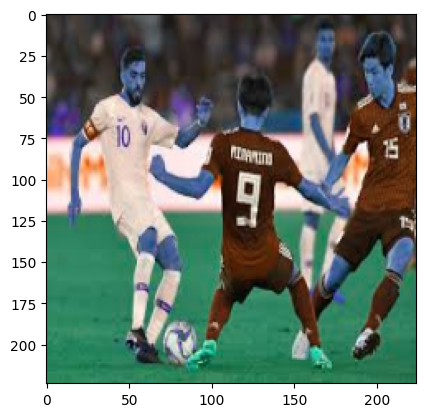

In [38]:
img_path='/kaggle/input/checkk/1.jpg'

img = cv2.imread(img_path)

img_resized = cv2.resize(img, (224, 224))

plt.imshow(img_resized)

img_normalized = img_resized / 255.0

img_normalized = np.expand_dims(img_normalized, axis=0)

print(img_normalized.shape)  

img_normalized = np.array(img_normalized)

print(img_normalized)

In [39]:
a=my_model.predict(img_normalized)

1/1 [==============================] - 0s 25ms/step


In [40]:
a[0][0]

0.48180208

In [41]:
my_model.save('modell.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
